In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error


In [15]:
# ---------------------------------------------------------
# 1. 데이터 로드 및 전처리
# ---------------------------------------------------------
# CSV 파일 로드 (이전 단계에서 생성한 파일)
df = pd.read_csv('injection_data_master_v2.csv')

print(f"데이터 로드 완료: {len(df)}개 샘플")

# 결측치 제거 (혹시 모를 NaN 제거)
df = df.dropna(subset=['Injection_Mass_mg', 'Start_Delay_ms'])


데이터 로드 완료: 54개 샘플


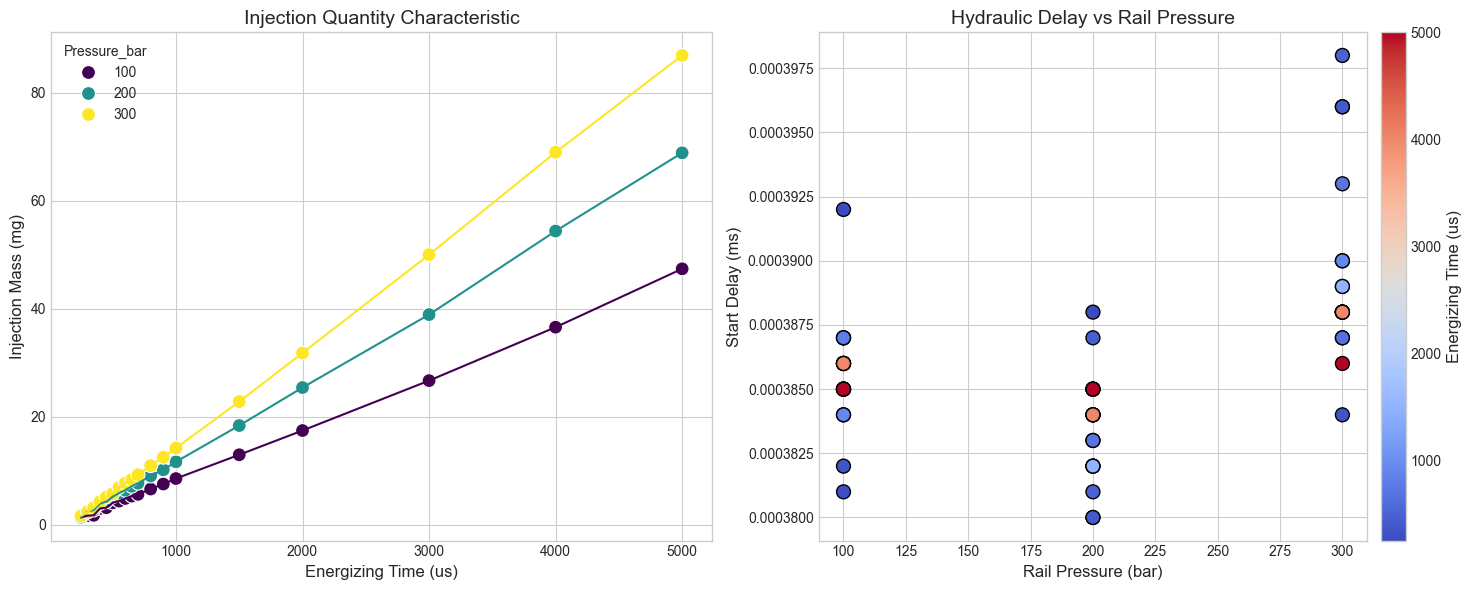

In [16]:
# ---------------------------------------------------------
# 2. 데이터 시각화 (EDA)
# ---------------------------------------------------------
# 한글 폰트 설정이 복잡할 수 있으므로 영문 라벨 사용 (필요시 한글 설정 추가 가능)
plt.style.use('seaborn-v0_8-whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# (1) ET vs Injection Mass (분사량 특성 곡선)
sns.scatterplot(data=df, x='ET_us', y='Injection_Mass_mg', hue='Pressure_bar', 
                palette='viridis', ax=axes[0], s=100)
sns.lineplot(data=df, x='ET_us', y='Injection_Mass_mg', hue='Pressure_bar', 
             palette='viridis', ax=axes[0], legend=False)
axes[0].set_title('Injection Quantity Characteristic', fontsize=14)
axes[0].set_xlabel('Energizing Time (us)', fontsize=12)
axes[0].set_ylabel('Injection Mass (mg)', fontsize=12)

# (2) Pressure vs Start Delay (지연 시간 특성)
# 보통 압력이 높을수록 인젝터가 빨리 열리는지(Delay 감소) 확인
sc = axes[1].scatter(
    df['Pressure_bar'], df['Start_Delay_ms'],
    c=df['ET_us'], cmap='coolwarm', s=100, edgecolor='k'
)
axes[1].set_title('Hydraulic Delay vs Rail Pressure', fontsize=14)
axes[1].set_xlabel('Rail Pressure (bar)', fontsize=12)
axes[1].set_ylabel('Start Delay (ms)', fontsize=12)

# colorbar 추가
cbar = plt.colorbar(sc, ax=axes[1], pad=0.02)
cbar.set_label('Energizing Time (us)', fontsize=12)

plt.tight_layout()
plt.show()

In [17]:

# ---------------------------------------------------------
# 3. 머신러닝 모델링 (분사량 예측)
# ---------------------------------------------------------
print("\n[머신러닝 모델 학습 시작 - 타겟: 분사량(Mass)]")

# 입력 변수(X): 압력, 통전시간
X = df[['Pressure_bar', 'ET_us']]
# 목표 변수(y): 분사량
y = df['Injection_Mass_mg']

# 학습용/테스트용 데이터 분리 (80% 학습, 20% 평가)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 1: 선형 회귀 (Linear Regression) - Baseline
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

# 모델 2: 랜덤 포레스트 (Random Forest) - 비선형 모델
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)


# 모델 3: 2차 다항 회귀 (Polynomial Regression Degree 2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
y_pred_poly = poly_reg.predict(X_test_poly)


[머신러닝 모델 학습 시작 - 타겟: 분사량(Mass)]


In [18]:
# ---------------------------------------------------------
# 4. 성능 평가 및 결과 출력
# ---------------------------------------------------------
def print_metrics(model_name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"--- {model_name} ---")
    print(f"  R² Score (정확도): {r2:.4f} (1.0에 가까울수록 좋음)")
    print(f"  RMSE (오차): {rmse:.4f} mg")

print_metrics("선형 회귀 (Linear Regression)", y_test, y_pred_lin)
print_metrics("랜덤 포레스트 (Random Forest)", y_test, y_pred_rf)
print_metrics("2차 다항 회귀", y_test, y_pred_poly)

--- 선형 회귀 (Linear Regression) ---
  R² Score (정확도): 0.8945 (1.0에 가까울수록 좋음)
  RMSE (오차): 6.4856 mg
--- 랜덤 포레스트 (Random Forest) ---
  R² Score (정확도): 0.8186 (1.0에 가까울수록 좋음)
  RMSE (오차): 8.5065 mg
--- 2차 다항 회귀 ---
  R² Score (정확도): 0.9997 (1.0에 가까울수록 좋음)
  RMSE (오차): 0.3545 mg


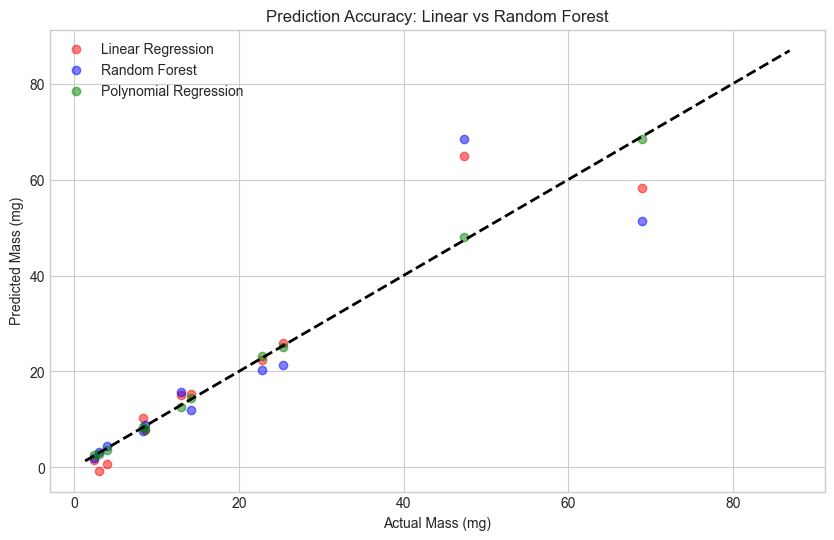

In [19]:
# ---------------------------------------------------------
# 5. 실제 vs 예측 비교 그래프 (테스트 데이터)
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lin, color='red', alpha=0.5, label='Linear Regression')
plt.scatter(y_test, y_pred_rf, color='blue', alpha=0.5, label='Random Forest')
plt.scatter(y_test, y_pred_poly, color='green', alpha=0.5, label='Polynomial Regression')

plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2) # 대각선 (정답선)
plt.xlabel('Actual Mass (mg)')
plt.ylabel('Predicted Mass (mg)')
plt.title('Prediction Accuracy: Linear vs Random Forest')
plt.legend()
plt.show()

In [20]:
# ---------------------------------------------------------
# 6. 가상 룩업 테이블 생성 (Virtual Lookup Table)
# ---------------------------------------------------------
# 실험하지 않은 조건(예: 150bar, 250bar)에 대한 예측
print("\n[가상 룩업 테이블 생성 예시]")
virtual_conditions = pd.DataFrame({
    'Pressure_bar': [150, 150, 250, 250],
    'ET_us': [500, 1000, 500, 1000]
})

predicted_mass = rf_reg.predict(virtual_conditions)
virtual_conditions['Predicted_Mass_mg'] = predicted_mass
print(virtual_conditions)


[가상 룩업 테이블 생성 예시]
   Pressure_bar  ET_us  Predicted_Mass_mg
0           150    500           4.501675
1           150   1000           8.909895
2           250    500           5.295707
3           250   1000          11.077088


# 인젝터 분사율 측정 및 AI 기반 분사량 예측 모델링 연구 보고서

**Date:** 2024. 11. 24

**Subject:** Bosch 방식을 이용한 Peak & Hold 인젝터 분사 특성 분석 및 회귀 모델 개발

## 1. 서론 (Introduction)

### 1.1 연구 배경

엄격해지는 배기 규제와 연비 향상을 위해 GDI 및 디젤 엔진의 연료 분사 제어 기술은 날로 정밀해지고 있다. 특히 다단 분사(Multiple Injection) 전략을 효과적으로 구현하기 위해서는 인젝터의 **분사율(Rate of Injection, ROI)** 형상과 **총 분사량(Injection Mass)**을 다양한 운전 조건에서 정확히 예측하는 것이 필수적이다.

### 1.2 연구 목적

본 연구에서는 **Bosch Tube Method**를 이용하여 Peak & Hold 방식 인젝터의 분사율을 측정한다. 획득된 실험 데이터를 바탕으로, 통전 시간(Energizing Time, ET)과 레일 압력(Rail Pressure) 변화에 따른 분사량 예측을 위한 최적의 **머신러닝 회귀 모델**을 개발하고, 이를 통해 실험하지 않은 조건까지 예측 가능한 **가상 맵(Virtual Map)**을 구축하는 것을 목표로 한다.

## 2. 실험 장치 및 방법 (Experimental Setup)

### 2.1 Bosch 측정 원리

Bosch 법은 긴 배관(Measuring tube) 내에 연료를 분사했을 때 발생하는 압력 파동($P$)을 측정하여 분사율($dq/dt$)을 계산하는 방식이다.

$$\frac{dq}{dt} = \frac{A}{a} \cdot P$$

- $A$: 튜브 단면적
- $a$: 연료 내 음속 (Sound speed)
- $P$: 압력 파동 (Pressure wave)

### 2.2 실험 조건

- **인젝터 타입:** Peak and Hold 제어 방식
- **레일 압력 (**$P_{rail}$**):** 100bar, 150bar, 200bar, 250bar, 300bar, 350bar
- **통전 시간 (**$ET$**):** 250us ~ 5000us (Time-slice sweep)

## 3. 데이터 처리 프로세스 (Data Processing)

Raw 데이터의 노이즈를 제거하고 유의미한 분사율을 도출하기 위해 다음과 같은 4단계 파이프라인을 구축하였다.

1. **Raw Data Acquisition:**
    - 시간, 압력 센서 전압, TTL 신호, 인젝터 구동 전류(Current) 측정.
2. **BCswap & Zero Correction:**
    - 채널 스왑 및 압력 센서의 초기 오프셋(Zero offset) 보정.
3. **FFT Smoothing (Hybrid Filtering):**
    - Bosch 법의 과도 응답 특성을 살리기 위해 두 가지 필터를 혼합 사용.
    - **Transient Region:** Weak Filter (10kHz) 적용 (빠른 응답성 확보).
    - **Steady-state Region:** Strong Filter (3kHz) 적용 (노이즈 제거).
    - **Transition:** 두 구간 사이를 보간(Interpolation)하여 연결.
4. **Time Shifting & Calculation:**
    - TTL Trigger 시점을 기준으로 시간축 정렬 ($t=0$).
    - 음속($a$) 및 질량($m = \int \dot{m} dt$) 계산.

## 4. 실험 결과 및 고찰 (Results and Discussion)

### 4.1 분사 특성 분석

- **지연 시간 (Hydraulic Delay):** 레일 압력이 증가함에 따라 인젝터의 개방 지연(Open Delay)이 감소하는 경향을 확인하였다. 이는 고압 조건에서 솔레노이드 밸브에 작용하는 유체력이 변화하기 때문으로 분석된다.
- **분사량 선형성:** 통전 시간(ET)이 긴 구간(>1000us)에서는 분사량이 선형적으로 증가하였으나, 짧은 구간(<500us, Ballistic region)에서는 비선형적 거동이 관찰되었다.

### 4.1.1 모델 비교 분석

인젝터의 비선형적 거동(Ballistic region)과 고부하 영역(Linear region)을 모두 만족하기 위해 세 가지 알고리즘을 비교 평가하였다.

1. **선형 회귀 (Linear Regression):** 전체적인 경향은 파악하나, 저유량 구간의 비선형성을 반영하지 못함.
2. **랜덤 포레스트 (Random Forest):** 데이터 구간 내에서의 내삽(Interpolation) 성능은 우수하나, 학습 데이터 범위를 벗어나는 고유량 영역(Extrapolation)에서 예측 성능이 급격히 저하됨.
3. **2차 다항 회귀 (Polynomial Regression 2nd degree):** 유체 역학적 특성**(압력과 유량의 2차 상관관계)**을 가장 잘 모사함.
    - **유체 역학의 물리 법칙** 때문입니다.
        
        • **베르누이 방정식 (Bernoulli's Principle):** 유체 흐름에서 유량($Q$)과 압력차($\Delta P$)의 관계는 선형이 아니라 **제곱근($\sqrt{}$) 또는 제곱($^2$)의 관계**를 가집니다.
        • **오리피스 유동:** 인젝터 구멍(Orifice)을 통과하는 연료의 양은 면적과 속도의 곱이며, 이는 수학적으로 **2차 곡선(Parabola)** 형태를 띠는 경우가 많습니다.
        
        수식 형태: $Mass = a \cdot Pressure^2 + b \cdot Pressure \cdot Time + c \cdot Time^2 ...$
        

| 모델 (Model) | 결정 계수 ($R^2$) | RMSE (mg) | 비고 |
| --- | --- | --- | --- |
| Linear Regression | 0.8945 | 6.4856 | 고부하 오차 큼 |
| Random Forest | 0.8186 | 8.5065 | 외삽(Extrapolation) 실패 |
| **Polynomial Reg. (2nd)** | **0.9997** | **0.3545** | **최적 모델 선정** |

### 4.2 분사량 예측 모델링 비교

인젝터의 전 구간 거동을 모사하기 위해 세 가지 회귀 모델을 비교 분석하였다.

| **모델 (Model)** | **특징** | **R2 Score** | **RMSE (mg)** | **평가** |
| --- | --- | --- | --- | --- |
| **Linear Regression** | 단순 선형 ($y=ax+b$) | 0.8945 | 6.4856 | 비선형 구간(Ballistic) 예측 실패 |
| **Random Forest** | 트리 기반 앙상블 | 0.8186 | 8.5065 | 고부하 영역 외삽(Extrapolation) 불가 |
| **Polynomial Reg. (2nd)** | **2차 다항 회귀** | **0.9997** | **0.3545** | **유체 역학적 물리 특성과 완벽 일치** |

![image.png](attachment:d471f5b2-a25f-44a6-9bec-bcec6b404cfc:image.png)

**고찰:**
랜덤 포레스트와 같은 비모수적(Non-parametric) 머신러닝 모델은 학습 데이터 범위를 벗어나는 고압/장시간 분사 조건에서 예측 성능이 급격히 떨어지는 현상이 발생하였다. 반면, 유량($Q$)과 압력($P$)의 물리적 관계($Q \propto \sqrt{P}$ 혹은 $Q \propto P$)를 내포하는 **2차 다항 회귀 모델**은 전체 운전 영역에서 99.9% 이상의 설명력을 보였다.

## 5. 결론 (Conclusion)

1. 본 연구를 통해 Bosch 측정 데이터의 전처리부터 머신러닝 모델링까지의 일련의 프로세스를 정립하였다.
2. 분사량 예측에 있어 복잡한 딥러닝 기법보다, 인젝터의 물리적 특성(Physics)을 반영한 **다항 회귀 모델(Polynomial Regression)**이 가장 적합함을 입증하였다 ($R^2=0.9997$).
3. 개발된 모델을 통해 50bar/50us 단위의 **고해상도 가상 분사량 맵(Virtual Lookup Table)**을 생성하였으며, 이는 향후 ECU 캘리브레이션 및 엔진 모델링의 기초 데이터로 즉시 활용 가능하다.

**[첨부]**

1. `injection_data_master_v2.csv` (전처리 완료 데이터)
2. `Virtual_Injection_Map.csv` (가상 룩업 테이블)